In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske

import tensorflow as tf
#from tensorflow.contrib import skflow
#import tensorflow.contrib.learn.python.learn as learn
import tensorflow.contrib.learn as learn
import tensorflow.contrib.learn as skflow


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os
os.chdir("/Users/cesare.chung/Dropbox/2017ML/ML_Titanic")

titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

titanic_df.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
titanic_df['survived'].mean()

0.3819709702062643

In [4]:
titanic_df.groupby('pclass').mean()


,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


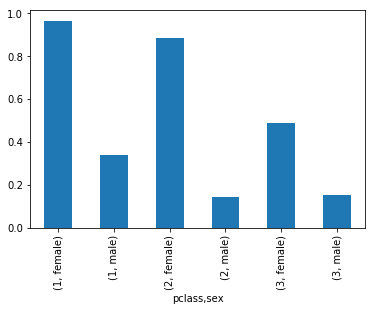

In [5]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
#class_sex_grouping

class_sex_grouping['survived'].plot.bar()

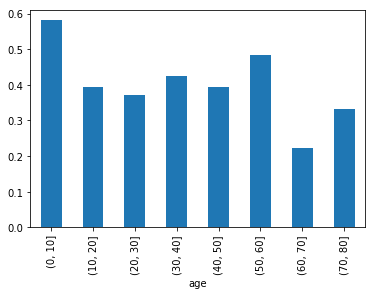

In [6]:
#
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()


In [7]:
titanic_df.count()


pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [8]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)


In [9]:
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")


In [10]:
titanic_df = titanic_df.dropna()

In [11]:
titanic_df.count()


pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [12]:
#
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df
#

In [13]:
processed_df = preprocess_titanic_df(titanic_df)

In [14]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values


In [15]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)


In [16]:
#
# Decision Tree
#
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [17]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)


0.77990430622009566

In [18]:
#
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))


In [19]:
test_classifier(clf_dt)


Accuracy: 0.7725 (+/- 0.02)


In [20]:
#
# Random Forest
#
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)


Accuracy: 0.7833 (+/- 0.02)


In [21]:
#
# Gradient Boosting
#
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)


Accuracy: 0.8201 (+/- 0.02)


In [22]:
# Voting
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)


Accuracy: 0.8074 (+/- 0.02)


In [24]:
##################################################
# dnn
##################################################
feature_columns = learn.infer_real_valued_columns_from_input(X_train)
feature_columns = learn.infer_real_valued_columns_from_input(X_test)

tf_clf_dnn = skflow.DNNClassifier(hidden_units=[20, 40, 20], n_classes=2, feature_columns=feature_columns)

tf_clf_dnn.fit(X_train, y_train, batch_size=256, steps=1000)

predictions_ = list(tf_clf_dnn.predict(X_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions_)
print("Accuracy: %f" % score)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_session_config': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_master': '', '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_is_chief': True, '_save_checkpoints_secs': 600, '_model_dir': '/var/folders/23/x8q8mbhn4x5g9wdl5twqb7s40000gn/T/tmpc1_fqjk_', '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11fe5a7f0>, '_task_type': None, '_num_worker_replicas': 0}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKC

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:260: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/23/x8q8mbhn4x5g9wdl5twqb7s40000gn/T/tmpc1_fqjk_/model.ckpt.
INFO:tensorflow:loss = 1.57909, step = 1
INFO:tensorflow:global_step/sec: 435.927
INFO:tensorflow:loss = 0.603263, step = 101 (0.231 sec)
INFO:tensorflow:global_step/sec: 405.477
INFO:tensorflow:loss = 0.588898, step = 201 (0.247 sec)
INFO:tensorflow:global_step/sec: 442.619
INFO:tensorflow:loss = 0.55242, step = 301 (0.226 sec)
INFO:tensorflow:global_step/sec: 438.417
INFO:tensorflow:loss = 0.533987, step = 401 (0.228 sec)
INFO:tensorflow:global_step/sec: 425.778
INFO:tensorflow:loss = 0.527586, step =

In [25]:
#
clf_rf.fit(X_train, y_train)
test_preds_rf = clf_rf.predict(X=X_test)

clf_gb.fit(X_train, y_train)
test_preds_gb = clf_gb.predict(X=X_test)

eclf.fit(X_train, y_train)
test_preds_vt = eclf.predict(X=X_test)

# Create a submission # DNN see below
submission = pd.DataFrame({"Actual" : y_test,
                           "Pred_rf": test_preds_rf,
                           "Pred_gb": test_preds_gb,
                           "Pred_vt": test_preds_vt,
                           "Pred_dnn":predictions_})
#


In [26]:
submission

,Actual,Pred_dnn,Pred_gb,Pred_rf,Pred_vt
0,0,0,0,0,0
1,0,0,0,1,0
2,1,1,1,1,1
3,0,0,0,0,0
4,0,0,0,0,0
5,1,0,0,0,0
6,0,0,0,0,0
7,1,0,1,1,1
8,1,1,0,0,0
9,0,0,0,0,0


In [27]:
passengers_set_1 = titanic_df[titanic_df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = titanic_df[titanic_df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = titanic_df[titanic_df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1,passengers_set_2,passengers_set_3])
testing_set = preprocess_titanic_df(passenger_set)
#
training_set = pd.concat([titanic_df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)
#

X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values


In [28]:
tf_clf_dnn.fit(X_train, y_train, batch_size=256, steps=1000)

predictions_ = list(tf_clf_dnn.predict(X_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions_)
print("Accuracy: %f" % score)



Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:260: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/23/x8q8mbhn4x5g9wdl5twqb7s40000gn/T/tmpc1_fqjk_/model.ckpt-1000
INFO:tensorflow:Saving checkpoints for 1001 into /var/folders/23/x8q8mbhn4x5g9wdl5twqb7s40000gn/T/tmpc1_fqjk_/model.ckpt.
INFO:tensorflow:loss = 0.543584, step = 1001
INFO:tensorflow:global_step/sec: 418.032
INFO:tensorflow:loss = 0.492806, step = 1101 (0.241 sec)
INFO:tensorflow:global_step/sec: 310.225
INFO:tensorflow:loss = 0.481192, step = 1201 (0.327 sec)
INFO:tensorflow:global_step/sec: 413.868
INFO:tensorflow:loss = 0.452392, step = 1301 (0.236 sec)
INFO:tensorflow:global_step/sec: 411.482
INFO:t

In [29]:
#tf_clf_dnn.fit (X_train, y_train)
#tf_clf_dnn.score (X_test, y_test)
#
predictions_ = list(tf_clf_dnn.predict(X_test, as_iterable=True))
passenger_set[passenger_set.survived != predictions_]


Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:260: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Restoring parameters from /var/folders/23/x8q8mbhn4x5g9wdl5twqb7s40000gn/T/tmpc1_fqjk_/model.ckpt-2000


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,S,"New York, NY"
14,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,"Hessle, Yorks"
16,1,0,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,C,"Montreal, PQ"
20,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,S,"New York, NY"
336,2,1,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S,"Norwich / New York, NY"
605,3,1,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,S,"Perkins County, SD"
606,3,1,"Abrahamsson, Mr. Abraham August Johannes",male,20.0,0,0,SOTON/O2 3101284,7.9250,S,"Taalintehdas, Finland Hoboken, NJ"
613,3,1,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,C,"Syria Fredericksburg, VA"
